In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from datetime import datetime

In [2]:
df = pd.read_csv('../data/processed/citibike_cleaned.csv')

C:\Users\21654\AppData\Local\Temp\ipykernel_16304\19600145.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/citibike_cleaned.csv')


In [3]:
df.head()  

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration
0,A8518A6C4BE513DE,classic_bike,2023-01-03 23:14:52.325,2023-01-03 23:33:42.737,E 1 St & Bowery,5636.13,Spruce St & Nassau St,5137.10,40.724861,-73.992131,40.711464,-74.005524,casual,18.840200
1,A3911E4F5B9B5773,electric_bike,2023-01-07 07:57:40.054,2023-01-07 08:01:27.330,E 1 St & Bowery,5636.13,Ave A & E 11 St,5703.13,40.724861,-73.992131,40.728547,-73.981759,casual,3.787933
2,AE7F74C32AEBF6F2,electric_bike,2023-01-09 18:37:44.830,2023-01-09 18:48:56.233,1 Ave & E 39 St,6303.01,E 14 St & 1 Ave,5779.10,40.747140,-73.971130,40.731393,-73.982867,member,11.190050
3,6E10997509D2B7F6,electric_bike,2023-01-05 19:06:15.350,2023-01-05 19:08:33.547,E Burnside Ave & Ryer Ave,8397.02,E Burnside Ave & Ryer Ave,8397.02,40.850535,-73.901318,40.850535,-73.901318,casual,2.303283
4,AA546E74A9330BD4,electric_bike,2023-01-02 20:25:23.300,2023-01-03 10:51:25.164,Clermont Ave & Park Ave,4692.01,Clermont Ave & Park Ave,4692.01,40.695734,-73.971297,40.695734,-73.971297,casual,866.031067


## Rideable Type Analysis

Let's explore the rideable_type column to understand bike type preferences and prepare it for modeling.

In [9]:
import matplotlib.pyplot as plt

In [4]:
# Explore rideable_type distribution
print("Rideable Type Value Counts:")
print(df['rideable_type'].value_counts())
print(f"\nUnique rideable types: {df['rideable_type'].nunique()}")
print(f"Rideable types: {df['rideable_type'].unique()}")

Rideable Type Value Counts:
rideable_type
electric_bike    17523302
classic_bike     17477428
Name: count, dtype: int64

Unique rideable types: 2
Rideable types: ['classic_bike' 'electric_bike']


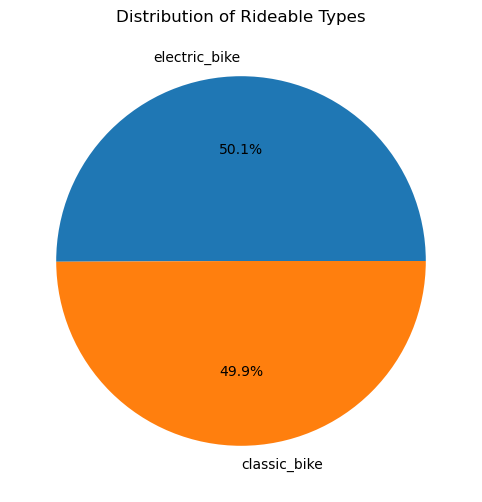

In [10]:
# Visualize rideable type distribution
plt.figure(figsize=(10, 6))
rideable_counts = df['rideable_type'].value_counts()
plt.pie(rideable_counts.values, labels=rideable_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Rideable Types')
plt.show()

## One-Hot Encoding for Rideable Type

Converting categorical rideable_type to numerical format for machine learning models.

In [11]:
# One-hot encode rideable_type
rideable_encoded = pd.get_dummies(df['rideable_type'], prefix='rideable')
print("One-hot encoded columns:")
print(rideable_encoded.columns.tolist())

# Add encoded columns to dataframe
df_encoded = pd.concat([df, rideable_encoded], axis=1)
print(f"\nDataframe shape after encoding: {df_encoded.shape}")

One-hot encoded columns:
['rideable_classic_bike', 'rideable_electric_bike']

Dataframe shape after encoding: (35000730, 16)


## Bike Type Preference Patterns Analysis

<Figure size 1200x600 with 0 Axes>

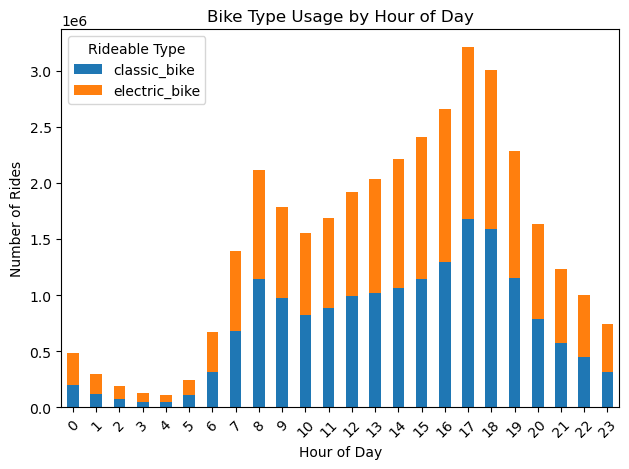

In [12]:
# Analyze bike type preferences by hour of day
if 'started_at' in df.columns:
    df['hour'] = pd.to_datetime(df['started_at']).dt.hour
    hourly_rideable = df.groupby(['hour', 'rideable_type']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(12, 6))
    hourly_rideable.plot(kind='bar', stacked=True)
    plt.title('Bike Type Usage by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Rides')
    plt.legend(title='Rideable Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

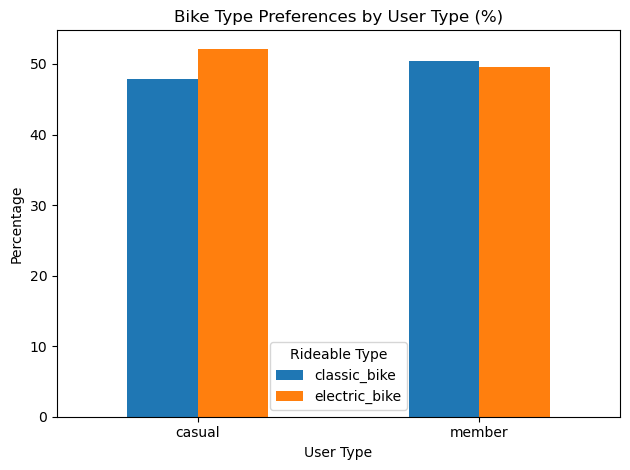

Bike type preferences by user type (%):
rideable_type  classic_bike  electric_bike
member_casual                             
casual                47.84          52.16
member                50.42          49.58


In [13]:
# Analyze bike type preferences by user type
if 'member_casual' in df.columns:
    user_rideable = pd.crosstab(df['member_casual'], df['rideable_type'], normalize='index') * 100
    
    plt.figure(figsize=(10, 6))
    user_rideable.plot(kind='bar')
    plt.title('Bike Type Preferences by User Type (%)')
    plt.xlabel('User Type')
    plt.ylabel('Percentage')
    plt.legend(title='Rideable Type')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("Bike type preferences by user type (%):")
    print(user_rideable.round(2))

In [22]:
import numpy as np
import seaborn as sns

In [24]:
# Define function to calculate Haversine distance (in kilometers)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of earth in kilometers
    
    return c * r

Distance Statistics (km):
count    3.500054e+07
mean     1.912348e+00
std      1.709881e+00
min      0.000000e+00
25%      7.854950e-01
50%      1.410196e+00
75%      2.485322e+00
max      2.773541e+01
Name: ride_distance_km, dtype: float64
count    3.500054e+07
mean     1.912348e+00
std      1.709881e+00
min      0.000000e+00
25%      7.854950e-01
50%      1.410196e+00
75%      2.485322e+00
max      2.773541e+01
Name: ride_distance_km, dtype: float64


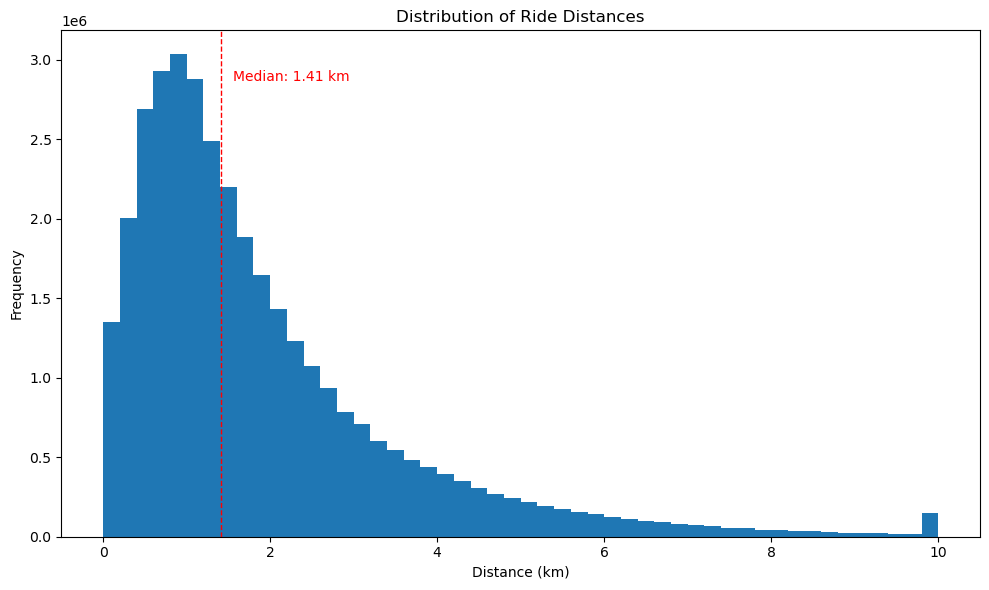

In [25]:
# Calculate the distance between start and end coordinates
if all(col in df.columns for col in ['start_lat', 'start_lng', 'end_lat', 'end_lng']):
    # Apply the haversine formula to calculate distance
    df['ride_distance_km'] = haversine_distance(
        df['start_lat'], df['start_lng'], df['end_lat'], df['end_lng']
    )
    
    # Show basic statistics of the calculated distances
    print("Distance Statistics (km):")
    print(df['ride_distance_km'].describe())
    
    # Plot histogram of distances
    plt.figure(figsize=(10, 6))
    plt.hist(df['ride_distance_km'].clip(upper=10), bins=50)  # Clip to 10km for better visualization
    plt.title('Distribution of Ride Distances')
    plt.xlabel('Distance (km)')
    plt.ylabel('Frequency')
    plt.axvline(df['ride_distance_km'].median(), color='red', linestyle='dashed', linewidth=1)
    plt.text(df['ride_distance_km'].median()*1.1, plt.ylim()[1]*0.9, 
             f'Median: {df["ride_distance_km"].median():.2f} km', color='red')
    plt.tight_layout()
    plt.show()
else:
    print("Missing required coordinate columns to calculate distance")

## Feature Engineering

Let's create the specified features to enhance our analysis and modeling capabilities:

In [27]:
from sklearn.cluster import KMeans 

In [28]:
# 1. trip_distance_km (rename existing ride_distance_km for consistency)
if 'ride_distance_km' in df.columns:
    df['trip_distance_km'] = df['ride_distance_km']
    
# 2. ride_speed_kmph
if 'ride_duration' in df.columns and 'trip_distance_km' in df.columns:
    # Convert ride_duration to hours and calculate speed
    # Avoid division by zero by setting a minimum duration
    df['ride_speed_kmph'] = df['trip_distance_km'] / (df['ride_duration'].clip(lower=1) / 60)
    
    # Remove extreme outliers (e.g., speeds > 50 km/h might be errors)
    df['ride_speed_kmph'] = df['ride_speed_kmph'].clip(upper=50)
    
    print("Speed Statistics (km/h):")
    print(df['ride_speed_kmph'].describe())

# 3. ride_time_bin
if 'hour' not in df.columns and 'started_at' in df.columns:
    df['hour'] = pd.to_datetime(df['started_at']).dt.hour

if 'hour' in df.columns:
    # Define time bins
    conditions = [
        (df['hour'] >= 5) & (df['hour'] < 12),   # Morning: 5 AM - 12 PM
        (df['hour'] >= 12) & (df['hour'] < 17),  # Midday: 12 PM - 5 PM
        (df['hour'] >= 17) & (df['hour'] < 21),  # Evening: 5 PM - 9 PM
        (df['hour'] >= 21) | (df['hour'] < 5)    # Night: 9 PM - 5 AM
    ]
    time_bins = ['Morning', 'Midday', 'Evening', 'Night']
    df['ride_time_bin'] = np.select(conditions, time_bins, default='Unknown')
    
    print("\nRide Time Bin Distribution:")
    print(df['ride_time_bin'].value_counts())

# 4. station_cluster (if station data available)
if all(col in df.columns for col in ['start_station_id', 'start_lat', 'start_lng']):
    # Create a unique set of stations
    stations = df[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates().reset_index(drop=True)
    
    # Apply KMeans clustering to group stations by geography
    if len(stations) >= 5:  # Ensure we have enough stations to cluster
        n_clusters = min(5, len(stations) - 1)  # Use 5 clusters or fewer if limited stations
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        stations['station_cluster'] = kmeans.fit_predict(stations[['start_lat', 'start_lng']])
        
        # Map clusters back to the original dataframe
        station_cluster_map = dict(zip(stations['start_station_id'], stations['station_cluster']))
        df['station_cluster'] = df['start_station_id'].map(station_cluster_map)
        
        print("\nStation Clusters Distribution:")
        print(df['station_cluster'].value_counts())

# 5. is_weekend
if 'started_at' in df.columns:
    df['day_of_week'] = pd.to_datetime(df['started_at']).dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # 5=Saturday, 6=Sunday
    
    print("\nWeekend vs. Weekday Distribution:")
    print(df['is_weekend'].value_counts().rename({0: 'Weekday', 1: 'Weekend'}))

# 6. is_peak_hour
if 'hour' in df.columns:
    # Define peak hours (7-9 AM, 4-7 PM)
    morning_peak = (df['hour'] >= 7) & (df['hour'] <= 9)
    evening_peak = (df['hour'] >= 16) & (df['hour'] <= 19)
    df['is_peak_hour'] = (morning_peak | evening_peak).astype(int)
    
    print("\nPeak Hour Distribution:")
    print(df['is_peak_hour'].value_counts().rename({0: 'Non-Peak', 1: 'Peak'}))

# 7. season
if 'started_at' in df.columns:
    df['month'] = pd.to_datetime(df['started_at']).dt.month
    
    # Define seasons
    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),    # Spring: Mar-May
        (df['month'] >= 6) & (df['month'] <= 8),    # Summer: Jun-Aug
        (df['month'] >= 9) & (df['month'] <= 11),   # Fall: Sep-Nov
        (df['month'] == 12) | (df['month'] <= 2)    # Winter: Dec-Feb
    ]
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    df['season'] = np.select(conditions, seasons, default='Unknown')
    
    print("\nSeason Distribution:")
    print(df['season'].value_counts())
    
# Show all new columns in the dataset
print("\nNew engineered features added:")
new_features = ['trip_distance_km', 'ride_speed_kmph', 'ride_time_bin', 'station_cluster', 
                'is_weekend', 'is_peak_hour', 'season']
existing_features = [feat for feat in new_features if feat in df.columns]
print(existing_features)

# Show the updated dataframe
df.head()

Speed Statistics (km/h):
count    3.500054e+07
mean     1.003728e+01
std      4.385311e+00
min      0.000000e+00
25%      7.525385e+00
50%      1.004830e+01
75%      1.275756e+01
max      5.000000e+01
Name: ride_speed_kmph, dtype: float64
count    3.500054e+07
mean     1.003728e+01
std      4.385311e+00
min      0.000000e+00
25%      7.525385e+00
50%      1.004830e+01
75%      1.275756e+01
max      5.000000e+01
Name: ride_speed_kmph, dtype: float64

Ride Time Bin Distribution:
ride_time_bin
Midday     11217808
Evening    10140717
Morning     9456039
Night       4186166
Name: count, dtype: int64

Ride Time Bin Distribution:
ride_time_bin
Midday     11217808
Evening    10140717
Morning     9456039
Night       4186166
Name: count, dtype: int64

Station Clusters Distribution:
station_cluster
0    17083891
1     7863084
4     6091851
3     2139219
2     1822685
Name: count, dtype: int64

Station Clusters Distribution:
station_cluster
0    17083891
1     7863084
4     6091851
3     2139219
2

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,ride_distance_km,trip_distance_km,ride_speed_kmph,ride_time_bin,station_cluster,day_of_week,is_weekend,is_peak_hour,month,season
0,A8518A6C4BE513DE,classic_bike,2023-01-03 23:14:52.325,2023-01-03 23:33:42.737,E 1 St & Bowery,5636.13,Spruce St & Nassau St,5137.10,40.724861,-73.992131,...,1.869051,1.869051,5.952330,Night,0,1,0,0,1,Winter
1,A3911E4F5B9B5773,electric_bike,2023-01-07 07:57:40.054,2023-01-07 08:01:27.330,E 1 St & Bowery,5636.13,Ave A & E 11 St,5703.13,40.724861,-73.992131,...,0.965365,0.965365,15.291156,Morning,0,5,1,1,1,Winter
2,AE7F74C32AEBF6F2,electric_bike,2023-01-09 18:37:44.830,2023-01-09 18:48:56.233,1 Ave & E 39 St,6303.01,E 14 St & 1 Ave,5779.10,40.747140,-73.971130,...,2.010913,2.010913,10.782329,Evening,0,0,0,1,1,Winter
3,6E10997509D2B7F6,electric_bike,2023-01-05 19:06:15.350,2023-01-05 19:08:33.547,E Burnside Ave & Ryer Ave,8397.02,E Burnside Ave & Ryer Ave,8397.02,40.850535,-73.901318,...,0.000000,0.000000,0.000000,Evening,2,3,0,1,1,Winter
4,AA546E74A9330BD4,electric_bike,2023-01-02 20:25:23.300,2023-01-03 10:51:25.164,Clermont Ave & Park Ave,4692.01,Clermont Ave & Park Ave,4692.01,40.695734,-73.971297,...,0.000000,0.000000,0.000000,Evening,4,0,0,0,1,Winter


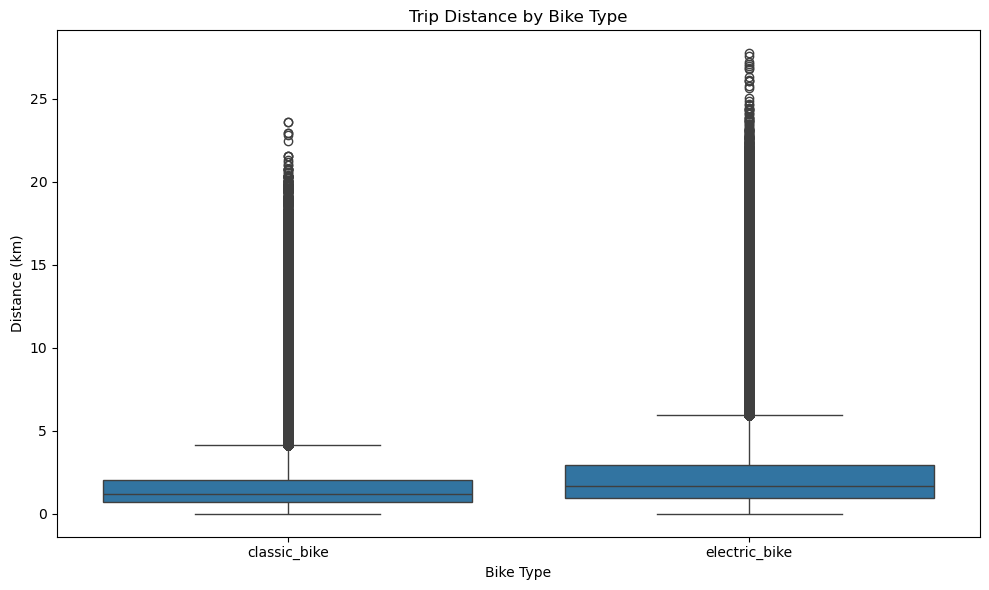

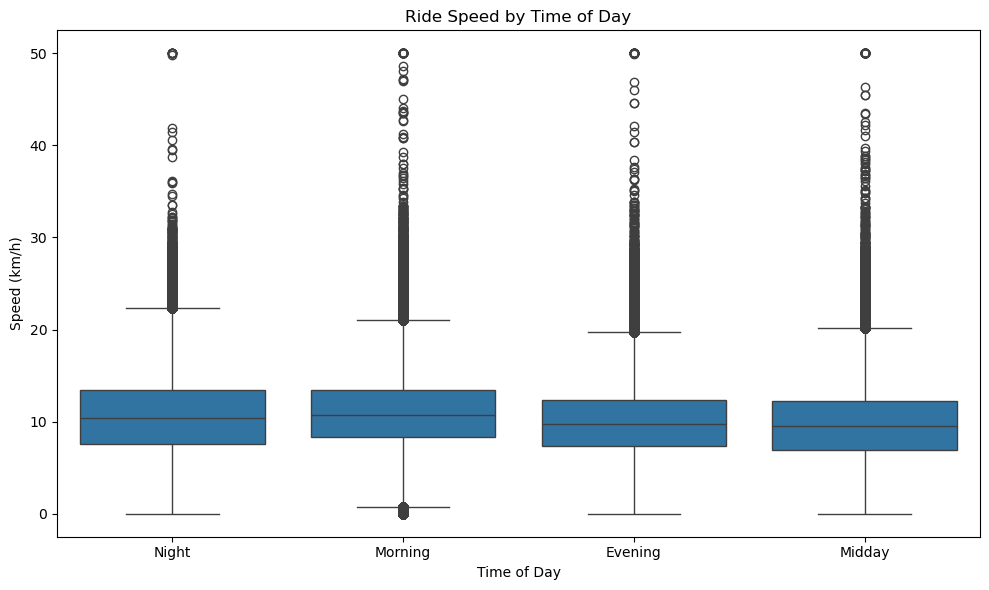

<Figure size 1000x600 with 0 Axes>

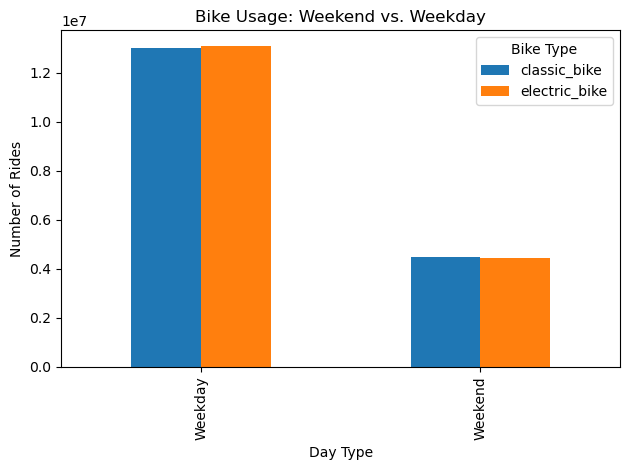

<Figure size 1200x600 with 0 Axes>

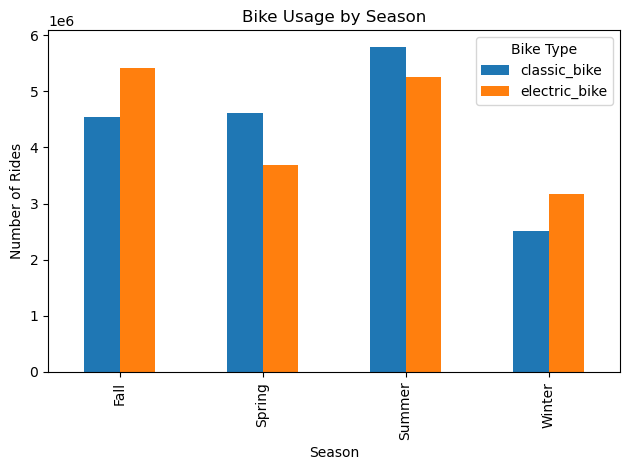

In [29]:
# Visualize the distribution of some of these new features

# 1. Trip Distance by Bike Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='rideable_type', y='trip_distance_km', data=df)
plt.title('Trip Distance by Bike Type')
plt.xlabel('Bike Type')
plt.ylabel('Distance (km)')
plt.tight_layout()
plt.show()

# 2. Ride Speed by Time of Day
if 'ride_speed_kmph' in df.columns and 'ride_time_bin' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ride_time_bin', y='ride_speed_kmph', data=df)
    plt.title('Ride Speed by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Speed (km/h)')
    plt.tight_layout()
    plt.show()

# 3. Weekend vs Weekday Usage
if 'is_weekend' in df.columns:
    weekend_counts = df.groupby(['is_weekend', 'rideable_type']).size().unstack()
    weekend_counts.index = weekend_counts.index.map({0: 'Weekday', 1: 'Weekend'})
    
    plt.figure(figsize=(10, 6))
    weekend_counts.plot(kind='bar')
    plt.title('Bike Usage: Weekend vs. Weekday')
    plt.xlabel('Day Type')
    plt.ylabel('Number of Rides')
    plt.legend(title='Bike Type')
    plt.tight_layout()
    plt.show()

# 4. Usage by Season
if 'season' in df.columns:
    season_counts = df.groupby(['season', 'rideable_type']).size().unstack()
    
    plt.figure(figsize=(12, 6))
    season_counts.plot(kind='bar')
    plt.title('Bike Usage by Season')
    plt.xlabel('Season')
    plt.ylabel('Number of Rides')
    plt.legend(title='Bike Type')
    plt.tight_layout()
    plt.show()

## Correlation Analysis

Let's examine the relationships between different features by creating a correlation matrix of all numeric columns.

Analyzing correlations for 14 numeric columns:
['start_lat', 'start_lng', 'end_lat', 'end_lng', 'ride_duration', 'hour', 'ride_distance_km', 'trip_distance_km', 'ride_speed_kmph', 'station_cluster', 'day_of_week', 'is_weekend', 'is_peak_hour', 'month']


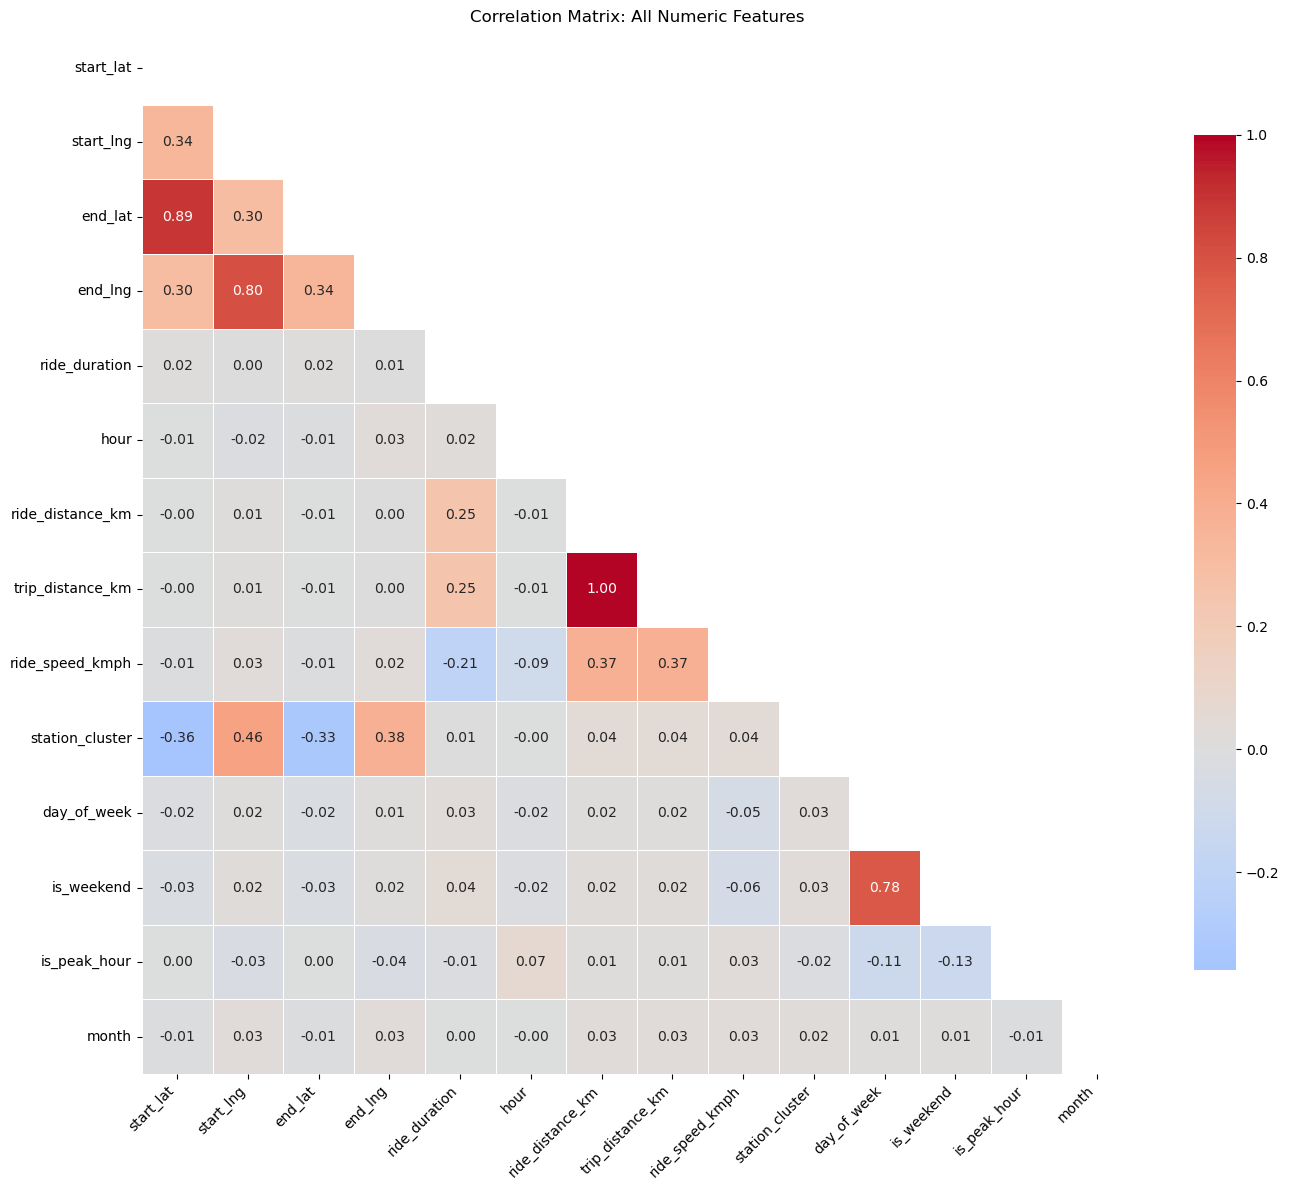


Top 10 strongest correlations:
end_lat — start_lat: 0.891
start_lat — end_lat: 0.891
end_lng — start_lng: 0.804
start_lng — end_lng: 0.804
is_weekend — day_of_week: 0.776
day_of_week — is_weekend: 0.776
station_cluster — start_lng: 0.458
start_lng — station_cluster: 0.458
end_lng — station_cluster: 0.381
station_cluster — end_lng: 0.381


In [30]:
# Create correlation matrix of all numeric columns
# Select only numeric columns to avoid errors
numeric_df = df.select_dtypes(include=[np.number])

# Print the numeric columns we'll analyze
print(f"Analyzing correlations for {len(numeric_df.columns)} numeric columns:")
print(numeric_df.columns.tolist())

# Create the correlation matrix
correlation_matrix = numeric_df.corr()

# Check if there are too many columns for a readable visualization
if len(correlation_matrix) > 20:
    print("\nCorrelation matrix is large. Showing a subset of important features.")
    # Focus on engineered features and select their highest correlations
    important_features = [col for col in numeric_df.columns if col in 
                         ['trip_distance_km', 'ride_speed_kmph', 'is_weekend', 
                          'is_peak_hour', 'station_cluster', 'hour', 'month']]
    
    # Get top correlations for each important feature
    top_corrs = {}
    for feature in important_features:
        if feature in correlation_matrix:
            # Get absolute correlations and sort
            feature_corrs = correlation_matrix[feature].abs().sort_values(ascending=False)
            # Keep top 5 correlations (excluding self-correlation)
            top_corrs[feature] = feature_corrs[1:6]
    
    # Print top correlations for each feature
    print("\nTop correlations for key features:")
    for feature, corrs in top_corrs.items():
        print(f"\n{feature}:")
        for col, val in corrs.items():
            print(f"  {col}: {correlation_matrix.loc[feature, col]:.3f}")
    
    # Create a focused correlation matrix with important features
    plt.figure(figsize=(12, 10))
    focused_matrix = correlation_matrix.loc[important_features, important_features]
    sns.heatmap(focused_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix: Key Features')
    plt.tight_layout()
    plt.show()
else:
    # If not too many columns, show the full correlation matrix
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create mask for upper triangle
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f',
                linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix: All Numeric Features')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Find the most significant correlations overall
print("\nTop 10 strongest correlations:")
# Unstack the correlation matrix, take absolute values, and sort
corr_unstack = correlation_matrix.abs().unstack()
# Drop self-correlations (which are always 1.0)
corr_unstack = corr_unstack[corr_unstack < 1.0]
top_corr = corr_unstack.sort_values(ascending=False)[:10]
for (feat1, feat2), corr_value in top_corr.items():
    # Display the actual correlation (not absolute value)
    actual_corr = correlation_matrix.loc[feat1, feat2]
    print(f"{feat1} — {feat2}: {actual_corr:.3f}")